In [68]:
import tensorflow
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding,LSTM, Conv2D, Dense, MaxPool2D, Dropout, TimeDistributed ,concatenate , ZeroPadding2D , Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("news_dataset_preprocessed_all.csv")

In [10]:
data = data[["title","content","label"]]

In [14]:
data.loc[data['label'] == "fake", 'label'] = 0
data.loc[data['label'] == "real", 'label'] = 1

c:\users\shini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\shini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


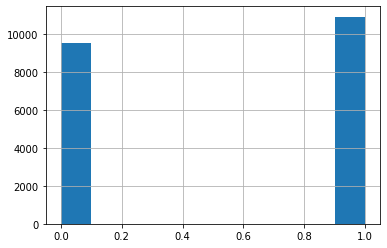

In [16]:
data.label.hist()

In [21]:
temp = data.copy()
for i in range(len(temp)):
    if len(temp.loc[i].content.split()) > 512:
        temp.drop(i,inplace=True)


In [25]:
temp = temp.reset_index()

In [28]:
temp_title = 0
for i in range(len(temp)):
    if temp_title < len(str(temp.loc[i].title).split()):
        temp_title = len(temp.loc[i].title.split())
print(temp_title)

In [30]:
#config for vocab
vocab_size = 40000
max_len_title = 64
max_len_content = 512

In [36]:
#train_test_split
X = temp[["title","content"]].astype(str)
y = temp["label"]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [39]:
# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train["title"])
tokenizer.fit_on_texts(x_train["content"])

In [34]:
#word to sequence and padding
def _preprocess_title(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len_title,
        padding='post',
    )

def _preprocess_content(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len_content,
        padding='post',
    )

In [42]:
#process the training set
x_train_title = _preprocess_title(x_train["title"])
x_train_content = _preprocess_content(x_train["content"])

In [46]:
#process the vaild(testing) set
x_valid_title = _preprocess_title(x_valid["title"])
x_valid_content = _preprocess_content(x_valid["content"])

In [77]:
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

In [84]:
y_train = y_train.astype("int32")
y_valid = y_valid.astype("int32")

In [65]:
#model_building

#input layers for title and content
input_title = Input(batch_shape=(None, max_len_title))
input_content = Input(batch_shape=(None, max_len_content))


#shared embedding layer
#shared_embedding = TimeDistributed(Embedding(tokenizer.num_words, 100))
shared_embedding = Embedding(tokenizer.num_words, 100)

#output of shared embedding layer
title_vec = shared_embedding(input_title)
content_vec = shared_embedding(input_content)

#lstm layers
lstm_title = tf.expand_dims(LSTM(100,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)(title_vec),-1)
lstm_content = tf.expand_dims(LSTM(100,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)(content_vec),-1)

#cnn layers
padding = ZeroPadding2D(((1, 0), (0, 1)))

CNN_title_3 = Conv2D(100,(3,3))(lstm_title)
CNN_title_4 = Conv2D(100,(4,4))(lstm_title)
CNN_title_5 = Conv2D(100,(5,5))(lstm_title)
pooling_title_3 = MaxPool2D(pool_size=(2, 2))(CNN_title_3)
pooling_title_4 = MaxPool2D(pool_size=(2, 2))(CNN_title_4)
pooling_title_5 = MaxPool2D(pool_size=(2, 2))(CNN_title_5)
pooling_title_4 = padding(pooling_title_4)
pooling_title_5 = padding(pooling_title_5)


CNN_content_3 = Conv2D(100,(3,3))(lstm_content)
CNN_content_4 = Conv2D(100,(4,4))(lstm_content)
CNN_content_5 = Conv2D(100,(5,5))(lstm_content)
pooling_content_3 = MaxPool2D(pool_size=(2, 2))(CNN_content_3)
pooling_content_4 = MaxPool2D(pool_size=(2, 2))(CNN_content_4)
pooling_content_5 = MaxPool2D(pool_size=(2, 2))(CNN_content_5)
pooling_content_4 = padding(pooling_content_4)
pooling_content_5 = padding(pooling_content_5)


CNN_out_title = concatenate([pooling_title_3, pooling_title_4,pooling_title_5])
CNN_out_content = concatenate([pooling_content_3,pooling_content_4,pooling_content_5])

CNN_out_title = Flatten()(CNN_out_title)
CNN_out_content = Flatten()(CNN_out_content)

#Dense layers
dense1_title = Dense(128,activation="relu")(CNN_out_title)
dense1_content = Dense(128,activation="relu")(CNN_out_content)
dense1 = concatenate([dense1_title, dense1_content])

dense2 = Dense(32,activation="relu")(dense1)

out = Dense(1,activation="sigmoid")(dense2)

model = Model(inputs=[input_title, input_content], outputs=out)

In [66]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         multiple             4000000     input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 64, 100)      80400       embedding_8[0][0]     

In [69]:
model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
)

In [86]:
history = model.fit([x_train_title,x_train_content],
                    y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=([x_valid_title,x_valid_content], y_valid),
                    verbose=1)

Epoch 1/5
236/236 [==============================] - 2062s 9s/step - loss: 0.4192 - accuracy: 0.8484 - auc: 0.9215 - val_loss: 0.2168 - val_accuracy: 0.9184 - val_auc: 0.9833
Epoch 2/5
236/236 [==============================] - 2101s 9s/step - loss: 0.0780 - accuracy: 0.9722 - auc: 0.9957 - val_loss: 0.1897 - val_accuracy: 0.9372 - val_auc: 0.9834
Epoch 3/5
236/236 [==============================] - 2260s 10s/step - loss: 0.0248 - accuracy: 0.9915 - auc: 0.9993 - val_loss: 0.2533 - val_accuracy: 0.9356 - val_auc: 0.9744
Epoch 4/5
236/236 [==============================] - 2277s 10s/step - loss: 0.0098 - accuracy: 0.9970 - auc: 0.9999 - val_loss: 0.3429 - val_accuracy: 0.9317 - val_auc: 0.9676
Epoch 5/5
236/236 [==============================] - 2257s 10s/step - loss: 0.0129 - accuracy: 0.9964 - auc: 0.9995 - val_loss: 0.2475 - val_accuracy: 0.9407 - val_auc: 0.9766


In [87]:
model.save_weights("500m_param_model_first_version")

In [88]:
def show_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [93]:
def show_accuracy(history):
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.1,1])
    plt.legend()
    plt.show()

In [90]:
def show_AUC(history):
    plt.plot(history.history['auc'],label='auc')
    plt.plot(history.history['val_auc'],label='val_auc')
    plt.xlabel('Epoch')
    plt.ylabel('Auc')
    plt.ylim([0.1,1])
    plt.legend()
    plt.show()

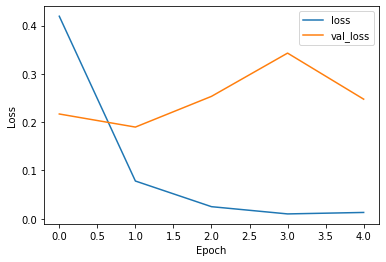

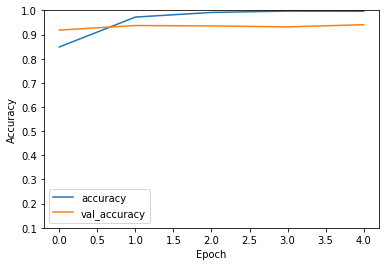

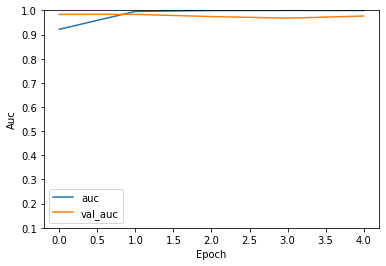

In [94]:
#plot the training performance
show_loss(history)
show_accuracy(history)
show_AUC(history)

In [96]:
#confusion matrix and report things
y_pred = model.predict([x_valid_title,x_valid_content])
y_pred = np.array([1 if y >= 0.5 else 0 for y in y_pred])
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))

[[1718  119]
 [ 105 1833]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1837
           1       0.94      0.95      0.94      1938

    accuracy                           0.94      3775
   macro avg       0.94      0.94      0.94      3775
weighted avg       0.94      0.94      0.94      3775

